In [6]:
%matplotlib inline
from pathlib import Path
import sys

PROJ_DIR = Path.cwd().parent
sys.path.append(str(PROJ_DIR))
assert PROJ_DIR.is_dir()

import copy
import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.pyplot import MultipleLocator
import numpy as np
import pandas as pd
import seaborn as sns
import os.path as osp
import json

sns.set(style="whitegrid", font_scale=1)
sns.set_palette(sns.color_palette('bright'))
# sns.set_palette([(0.0, 0.24705882352941178, 1.0),
#                  (0.011764705882352941, 0.9294117647058824, 0.22745098039215686),
#                  (0.9098039215686274, 0.0, 0.043137254901960784),
#                  (0.5411764705882353, 0.16862745098039217, 0.8862745098039215),
#                  (1.0, 0.7686274509803922, 0.0),
#                  (0.0, 0.8431372549019608, 1.0)])
sns.set_palette(
    np.array(
        [
            [219, 39, 40],  # red
            # [255, 127, 14], # orange
            [44, 160, 44],  # green
            [31, 119, 200],  # blue
            [148, 103, 189], # purple
            [140, 86, 75],  # brown
            [227, 119, 194], # pink
        ]
    ) / 255.0
)
fm.fontManager.addfont(str(PROJ_DIR / 'arial.ttf'))
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'Arial'
print(PROJ_DIR)

SMOOTHFACTOR = 0.9
SMOOTHFACTOR2 = 20
SMOOTHFACTOR3 = 20
DIV_LINE_WIDTH = 50
fontsize = 13
paper = True
env_name_dict = {
    'quadrotor': 'Quadrotor Circle Tracking',
    'safetygym-car': 'CarGoal',
    'safetygym-point': 'PointGoal',
    'cartpole-move': 'Cartpole-Move',
    'cartpole-upright': 'Cartpole-Upright',
}
tag_name_dict = {
    'episode_return': 'Episode return',
    'episode_constraint_violation': 'Episode constraint violation',
    'total_violation': 'Cumulative unsafe trajectories'
}

xlim_dict = {
    'quadrotor': np.array([0, 37.8]),
    'cartpole-move': np.array([0, 51]),
    'safetygym-car': np.array([0, 105]),
    'safetygym-point': np.array([0, 105]),
}

ylim_dict = {
    'episode_return': {
        'quadrotor': [-50, 650],
        'safetygym-car': [-2, 30],
        'safetygym-point': [-2, 28],
        'cartpole-move': [-10, 800],
        
    },
    'episode_constraint_violation': {
        'safetygym-point': [-2, 30],
        'safetygym-car': [-2, 20],
        'quadrotor': [-5, 50],
        'cartpole-move': [-2, 20]
    },
    'total_violation': {
        'safetygym-car': [0, 10],
        'quadrotor': [0, 50],
    }
}

on_policy_results = {
    'quadrotor': {
        'cpo': {
            'episode_return': 373.2,
            'episode_constraint_violation': 0.0,
            'total_violation': 2578.8
        },
        'ppo-lag': {
            'episode_return': 507.9,
            'episode_constraint_violation': 0.666,
            'total_violation': 909.8
        }
    },
    'cartpole-move': {
        'cpo': {
            'episode_return': 753.3,
            'episode_constraint_violation': 0.03,
            'total_violation': 2686
        },
        'ppo-lag': {
            'episode_return': 685.6,
            'episode_constraint_violation': 0.43,
            'total_violation': 2822.2
        }
    },
    'safetygym-point': {
        'cpo': {
            'episode_return': 23.14,
            'episode_constraint_violation': 4.748,
            'total_violation': 402.2
        },
        'ppo-lag': {
            'episode_return': 22.69,
            'episode_constraint_violation': 3.202,
            'total_violation': 375.2
        }
    },
    'safetygym-car': {
        'cpo': {
            'episode_return': 26.62,
            'episode_constraint_violation': 6.552,
            'total_violation': 381.6
        },
        'ppo-lag': {
            'episode_return': 25.69,
            'episode_constraint_violation': 3.89,
            'total_violation': 316.2
        }
    },
}

def is_eval_metric(metric: str):
    return metric.startswith('episode')

csv_col2tag = {
    'total violations': 'total_violation',
    'eval return mean': 'episode_return',
    'eval violation mean': 'episode_constraint_violation'
}
tag2csv_col = dict(zip(csv_col2tag.values(), csv_col2tag.keys()))
print(tag2csv_col)

/home/yudongjie/safe_proj/Safe_MBRL
{'total_violation': 'total violations', 'episode_return': 'eval return mean', 'episode_constraint_violation': 'eval violation mean'}


/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_pi/09-27-22_21.45.46_qc_of_pi/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_pi/09-27-22_20.10.12_qc_of_pi/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_pi/09-27-22_20.58.06_qc_of_pi/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_pi/09-27-22_19.22.19_qc_of_pi/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_pi/09-27-22_17.49.58_qc_of_pi/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_star/09-27-22_17.48.58_qc_star/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_star/09-27-22_20.58.04_qc_star/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_star/09-27-22_20.10.04_qc_star/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_star/09-27-22_19.22.07_qc_star/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_star/09-27-22_21.46.18_qc_star/eval.csv
/home/yudongjie/safe_proj/Safe_MBRL/logs/quadrotor/qh_star w/o sh

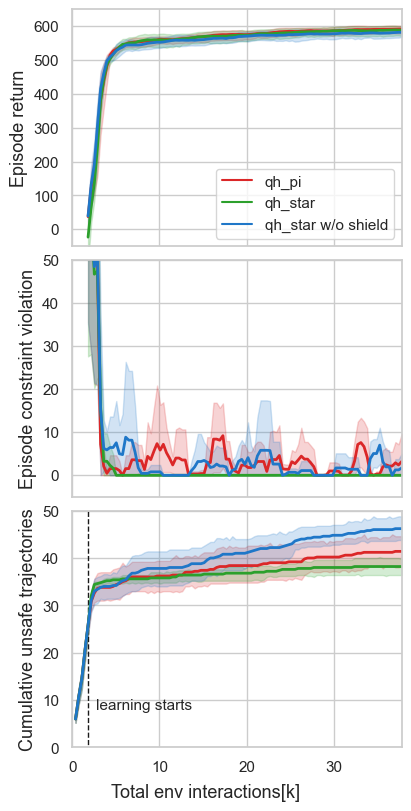

In [7]:
def help_func():
    tag2plot = ['episode_return', 'episode_constraint_violation', 'total_violation']
    alg_list = ['qh_pi', 'qh_star', 'qh_star w/o shield']
    result_dir = PROJ_DIR / 'logs'
    return tag2plot, alg_list, result_dir

def smooth(data, sm=1):
    '''Borrow from
    https://blog.csdn.net/qq_43280087/article/details/119894398
    '''
    if sm > 1:
        z = np.ones_like(data)
        y = np.ones(sm)*1.0
        d = np.convolve(y, data, "same")/np.convolve(y, z, "same")
    return d

def plot_eval_results_of_all_alg_n_runs(task):
    tag2plot, alg_list, result_dir = help_func()
    result_dir = result_dir / task
    assert result_dir.is_dir()

    train_in_one_run_of_one_alg = {}
    train_list = []

    eval_in_one_run_of_one_alg = {}
    eval_list = []

    for alg in alg_list:
        alg_results = result_dir / alg
        for run_idx, run_dir in enumerate([path for path in alg_results.iterdir() if path.is_dir()]):
            # read files
            eval_file = result_dir / run_dir / 'eval.csv'
            train_file = result_dir / run_dir / 'episodes.csv'
            cfg = result_dir / run_dir / 'config.json'
            print(eval_file)

            assert eval_file.is_file()
            assert train_file.is_file()
            assert cfg.is_file()
            df_train = pd.read_csv(train_file)
            df_eval = pd.read_csv(eval_file)

            # preprocess, add necessary columns
            with open(cfg, 'r') as f:
                cfg_dict = json.load(f)
            steps_per_epoch = cfg_dict['alg_cfg']['steps_per_epoch']
            epochs = cfg_dict['epochs']
            buffer_min = cfg_dict['alg_cfg']['buffer_min']
            if cfg_dict['alg_cfg']['alive_bonus'] > 0:
                df_eval.loc[:, 'eval return mean'] += cfg_dict['alg_cfg']['alive_bonus'] * df_eval.loc[:, 'eval length mean']

            df_eval.insert(
                len(df_eval.columns),
                'steps sampled',
                (buffer_min + np.arange(0, steps_per_epoch*epochs + 1, steps_per_epoch)) / 1e3
            ) 
            df_eval.insert(len(df_eval.columns), 'algorithm', alg)
            df_eval.insert(len(df_eval.columns), 'run_idx', run_idx)
            
            select_row = df_train.loc[:, 'steps sampled'] % steps_per_epoch == 0
            df_train = df_train[select_row]
            df_train.loc[:, 'steps sampled'] /= 1e3
            df_train.insert(len(df_train.columns), 'algorithm', alg)
            df_train.insert(len(df_train.columns), 'run_idx', run_idx)

            # add insterested columns (tag)
            for tag in tag2plot:
                if is_eval_metric(tag):
                    df_eval.insert(len(df_eval.columns), tag, smooth(df_eval.loc[:, tag2csv_col[tag]].tolist(), sm=4))
                else:
                    df_train.insert(
                        len(df_train.columns), tag, 
                        df_train.loc[:, tag2csv_col[tag]]
                    )
            train_list.append(df_train)
            eval_list.append(df_eval)
            # break
            # print(df_train[:10])

    total_train_df = train_list[0].append(train_list[1:], ignore_index=True) if len(train_list) > 1 else \
                     train_list[0]
    total_eval_df = eval_list[0].append(eval_list[1:], ignore_index=True) if len(eval_list) > 1 else \
                    eval_list[0]

    figsize = (4, 8)
    f, axes = plt.subplots(
                ncols=1, nrows=3, sharex=True, constrained_layout=True,
                gridspec_kw={
                    'height_ratios': [1, 1, 1]
                }
    )
    f.set_size_inches(figsize[0], figsize[1])
    f.supxlabel("Total env interactions[k]", fontsize=fontsize)
    for i, tag in enumerate(tag2plot):
        if i == 2: # total violations
            axes[i].plot([buffer_min / 1e3, buffer_min / 1e3], [-1, 1e3], '--k', linewidth=1) 
            plt.text((buffer_min*1.5) / 1e3, 8, 'learning starts', fontsize=fontsize-2)
        sns.lineplot(
            x="steps sampled", 
            y=tag, 
            hue="algorithm",
            data=total_eval_df if is_eval_metric(tag) else total_train_df,
            ax=axes[i],
            linewidth=2,
            # errorbar='sd'
        )
        axes[i].set_xlabel("")
        axes[i].set_ylabel(tag_name_dict[tag], fontsize=fontsize)
        ylim_range = ylim_dict[tag].get(task, None)
        if ylim_range:
            axes[i].set_ylim(ylim_range)
        axes[i].set_xlim(xlim_dict[task])

        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend()
        if i != 0:
            axes[i].get_legend().remove()
        axes[i].tick_params(labelsize=fontsize-2)

    if (PROJ_DIR / 'viz_curves').is_dir():
        pass
    else:
        (PROJ_DIR / 'viz_curves').mkdir()
    plt.savefig(str(PROJ_DIR)+'/viz_curves/'+task+'.pdf', bbox_inches='tight', dpi=300.0)


plot_eval_results_of_all_alg_n_runs('quadrotor')
# 


In [8]:
all_fonts = sorted([f.name for f in fm.fontManager.ttflist])
all_fonts

['Abyssinica SIL',
 'Ani',
 'AnjaliOldLipi',
 'Arial',
 'Arial',
 'Arial',
 'C059',
 'C059',
 'C059',
 'C059',
 'Chandas',
 'Chilanka',
 'D050000L',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Dhurjati',
 'Droid Sans Fallback',
 'Dyuthi',
 'FreeMono',
 'FreeMono',
 'FreeMono',
 'FreeMono',
 'FreeSans',
 'FreeSans',
 'FreeSans',
 'FreeSans',
 'FreeSerif',
 'FreeSerif',
 'FreeSerif',
 'FreeSerif',
 'Gargi',
 'Garuda',
 'Garuda',
 'Garuda',
 'Garuda',
 'Gayathri',
 'Gayathri',
 'Gayathri',
 'Gidugu',
 'Gubbi',
 'Gurajada',
 'Jamrul',
 'KacstArt',
 'KacstBook',
 'KacstDecorative',
 'KacstDigital',
 'KacstFarsi',
 'KacstLetter',
 'KacstNaskh',
 'KacstOffice',
 'Kacs